# SnowModel comparisons
---  
*J. Michelle Hu  
University of Utah  
Sept 2024*  


In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import geopandas as gpd
import xarray as xr
# import hvplot.xarray

from s3fs import S3FileSystem, S3Map

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/studio/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%reload_ext autoreload
%autoreload 2

### Env setup

In [3]:
from pathlib import PurePath
CONDA_ENV = 'studio'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem

pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj


### Directories and global variables

In [4]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/'
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts'
poly_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/polys'
# aso_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ASO'

# SNOTEL all sites geojson fn - snotel site json
allsites_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/snotel_sites_32613.json'

# nwm proj4 file
proj_fn = "/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/NWM_datasets_proj4.txt"

In [5]:
# Basin-specific variables
basin = 'blue'

In [6]:
if basin == 'blue':
    basindirs = [h.fn_list(workdir, f'*{basin}*')[1], h.fn_list(workdir, f'*{basin}*')[0]] # Blue River
elif basin == 'yampa':
    # basindirs =h.fn_list(workdir, f'__{basin}*') # Yampa River previous runs
    basindirs =h.fn_list(workdir, f'{basin}*') # Yampa River newest runs
elif basin == 'animas':
    basindirs = h.fn_list(workdir, f'__{basin}*') # Animas previous runs
    # basindirs = [h.fn_list(workdir, f'{basin}*')[0], h.fn_list(workdir, f'__{basin}*')[1]]
basindirs

['/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_river_100m_isnobal',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/__blue_river_100m_isnobal_solar_albedo']

In [7]:
# Get the WY from the directory name - assumes there is only one WY per basin
WY = int(h.fn_list(basindirs[0], '*')[0].split('/')[-1].split('wy')[-1])
print(WY)

2019


# Change to 2018, since that's all you have for SnowModel right now

In [8]:
WY = 2018

In [9]:
# Figure out filenames
# Basin polygon file if not in poly_dir, all should now be there
# poly_fn = h.fn_list(script_dir, f'*{basin}*setup/polys/*shp')[0]
poly_fn = h.fn_list(poly_dir, f'*{basin}*shp')[0]
print(poly_fn)

/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/polys/blue_river_basin_outline_HUC10dissolved_32613.shp


## Load and take a look at SnowModel outputs

In [10]:
snowmodel_dir = '/uufs/chpc.utah.edu/common/home/u6058223/SnowModel'
snowmodel_workdir = h.fn_list(snowmodel_dir, f'*{basin}*')[0]
snowmodel_workdir

'/uufs/chpc.utah.edu/common/home/u6058223/SnowModel/blue'

In [11]:
sm_files = h.fn_list(snowmodel_workdir, '*/*')

In [12]:
%%time
chunks = 'auto'
ds_list = [np.squeeze(xr.open_dataset(day_fn, chunks=chunks)) for day_fn in sm_files]

CPU times: user 3.81 s, sys: 619 ms, total: 4.43 s
Wall time: 6.08 s


In [13]:
len(ds_list)

256

In [14]:
sm_files[-1]

'/uufs/chpc.utah.edu/common/home/u6058223/SnowModel/blue/2018/sm_swed_20180627.nc'

In [15]:
sm_files[0]

'/uufs/chpc.utah.edu/common/home/u6058223/SnowModel/blue/2018/sm_swed_20171001.nc'

In [16]:
ds_list[0]

<xarray.Dataset> Size: 2MB
Dimensions:      (y: 741, x: 572)
Coordinates:
  * y            (y) float64 6kB 4.433e+06 4.433e+06 ... 4.357e+06 4.357e+06
  * x            (x) float64 5kB 3.745e+05 3.746e+05 ... 4.333e+05 4.334e+05
    date         datetime64[ns] 8B 2017-10-01
Data variables:
    spatial_ref  int64 8B ...
    swed         (y, x) float32 2MB dask.array<chunksize=(741, 572), meta=np.ndarray>

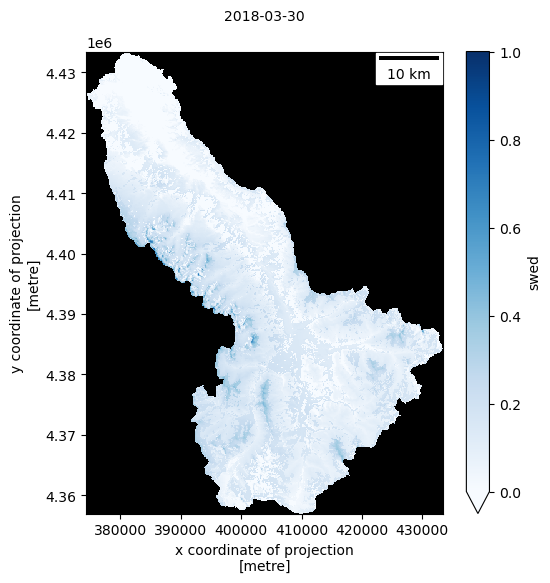

In [17]:
jdx = 180
title = pd.Timestamp(ds_list[jdx].date.values).strftime('%Y-%m-%d')
figsize = (6,6)
h.plot_one(ds_list[jdx]['swed'], title=title, figsize=figsize, sd_switch=True, setfc='k', vmin=0, vmax=1)

### SNOTEL extraction and point specification
- identify SNOTEL sites within the specified basin
- extract site metadata (site name, site number, and coordinates)
- extract snow depth values for WY of interest

In [18]:
# Locate SNOTEL sites within basin
found_sites = proc.locate_snotel_in_poly(poly_fn=poly_fn, site_locs_fn=allsites_fn)

# Get site names and site numbers
sitenames = found_sites['site_name']
sitenums = found_sites['site_num']
print(sitenames)

155    Copper Mountain (415)
167       Fremont Pass (485)
170       Grizzly Peak (505)
Name: site_name, dtype: object


In [19]:
def get_snotel(sitenum, sitename, ST, WY, epsg=32613):
    '''Use metloom to pull snotel coordinates and return as geodataframe and daily data as dict of dataframes'''
    from metloom.pointdata import SnotelPointData
    import geopandas as gpd
    from shapely.geometry import Point
    from datetime import datetime
    
    # start and end date
    start_date = datetime(WY-1, 10, 1)
    end_date = datetime(WY, 9, 30)

    snotel_dfs = dict()
    snotellats = []
    snotellons = []
    for snotelNUM, snotelNAME, snotelST in zip(sitenum, sitename, ST):
        snotel_point = SnotelPointData(f"{snotelNUM}:{snotelST}:SNTL", f"{snotelNAME}")

        meta_df = snotel_point.metadata
        lon, lat = meta_df.x, meta_df.y
        snotellats.append(lat)
        snotellons.append(lon)
        
        # set up variable list
        # variables = [snotel_point.ALLOWED_VARIABLES.SNOWDEPTH]
        variables = [snotel_point.ALLOWED_VARIABLES.SWE]

        # request the data - use daily, the hourly data is too noisy and messes up SDD calcs
        df = snotel_point.get_daily_data(start_date, end_date, variables)
        # df = snotel_point.get_hourly_data(start_date, end_date, variables)

        # Convert to metric here
        # df['SNOWDEPTH_m'] = df['SNOWDEPTH'] * 0.0254
        df['SWE_m'] = df['SWE'] * 0.0254
        
        # Reset the index 
        df = df.reset_index().set_index("datetime")

        # Store in dict
        snotel_dfs[snotelNAME] = df
    
    # Create a Geoseries based off of a list of a Shapely point using the lat and lon from the SNOTEL site
    s = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(snotellons, snotellats)])

    # Turn this into a geodataframe and specify the geom as the geoseries of the SNOTEL point
    gdf = gpd.GeoDataFrame(geometry=s)

    # Set the CRS inplace
    gdf.set_crs('epsg:4326', inplace=True)

    # Convert snotel coords' lat lon to UTM
    gdf = gdf.to_crs(f'epsg:{epsg}')

    return gdf, snotel_dfs

In [20]:
ST_arr = ['CO'] * len(sitenums)
gdf_metloom, snotel_dfs = get_snotel(sitenums, sitenames, ST_arr, WY=WY)
gdf_metloom

,geometry
0,POINT (399255.157 4371717.635)
1,POINT (396832.750 4359646.780)
2,POINT (425406.434 4388880.047)


<Axes: xlabel='datetime'>

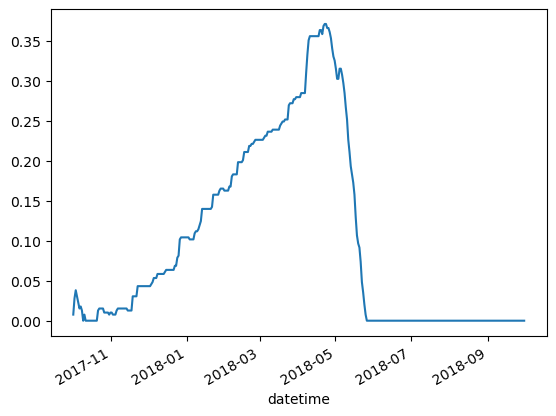

In [21]:
snotel_dfs[sitenames.iloc[0]]["SWE_m"].plot()

## Extract SnowModel data at these sites

In [22]:
%%time
snow_var_data = [ds.sel(x=list(gdf_metloom.geometry.x.values), y=list(gdf_metloom.geometry.y.values), method='nearest') for ds in ds_list]

# Concatenate all the days to form a time series
depth_ts = xr.concat(snow_var_data, dim='time')

CPU times: user 3.12 s, sys: 519 ms, total: 3.64 s
Wall time: 6.03 s


In [23]:
depth_ts

<xarray.Dataset> Size: 13kB
Dimensions:      (time: 256, y: 3, x: 3)
Coordinates:
  * y            (y) float64 24B 4.372e+06 4.36e+06 4.389e+06
  * x            (x) float64 24B 3.992e+05 3.968e+05 4.254e+05
    date         (time) datetime64[ns] 2kB 2017-10-01 2017-10-02 ... 2018-06-27
Dimensions without coordinates: time
Data variables:
    spatial_ref  (time) int64 2kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    swed         (time, y, x) float32 9kB dask.array<chunksize=(1, 3, 3), meta=np.ndarray>

## Plot em up 

In [24]:
# Plotting params
linewidth = 1.5

snotelcolor = 'dimgray'
isnobalcolors = ['mediumblue', 'cornflowerblue']
isnobal_alpha = 0.6


Copper Mountain (415)

Fremont Pass (485)

Grizzly Peak (505)


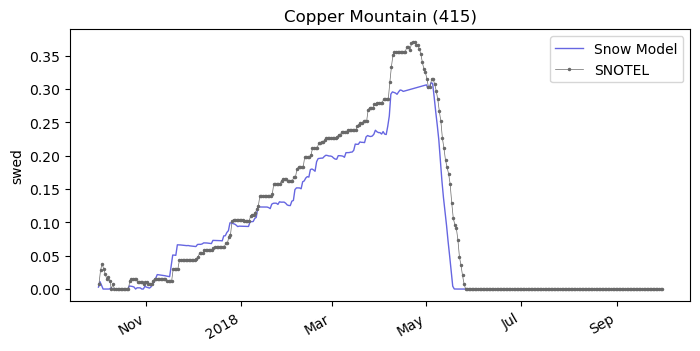

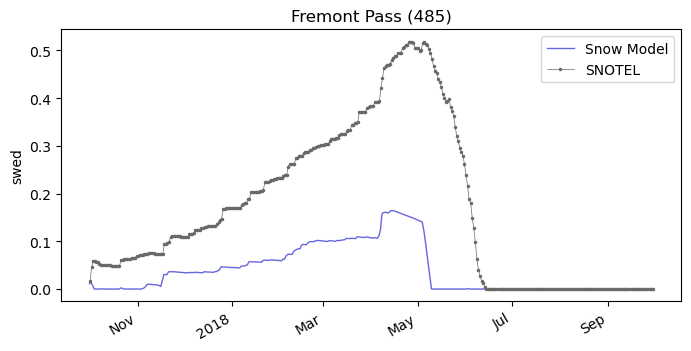

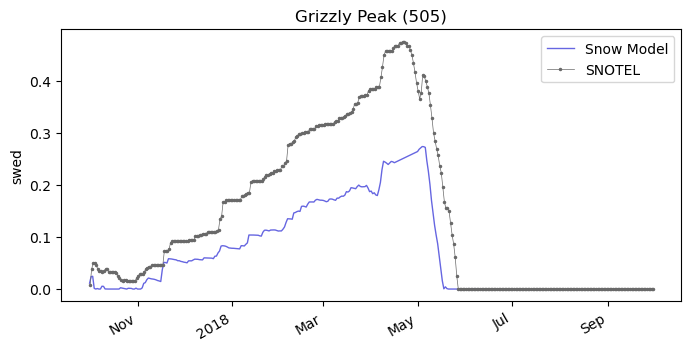

In [53]:
# No SDD version
figsize = (8, 4)
for jdx, (sitenum, sitename) in enumerate(zip(sitenums, sitenames)):
    # Extract SNOTEL data for this site
    snotel_df = snotel_dfs[sitename]
    print(f'\n{sitename}')

    # Extract model data for this site
    sm_ts = depth_ts['swed'][:, jdx, jdx]

    fig, ax = plt.subplots(1, figsize=figsize)
    sm_ts.plot(ax=ax, x='date', color=isnobalcolors[0], label='Snow Model', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)

    # Plot WY time series of snow depth
    snotel_df['SWE_m'].plot(ax=ax, label=f'SNOTEL',
                                    # linestyle=(0, (3, 1, 1, 1, 1, 1)),
                                    linewidth=linewidth/3,
                                    color=snotelcolor, marker='.', markersize=3,
                                    )
    
    plt.legend()
    plt.title(f'{sitename}')
    plt.xlabel('');


In [32]:
depth_list = []
snotel_list = []

for jdx, (sitenum, sitename) in enumerate(zip(sitenums, sitenames)):
    depth_list.append(depth_ts['swed'][:, jdx, jdx].to_series())
    snotel_list.append(snotel_dfs[sitenames.iloc[jdx]]['SWE_m'])
    
depth_megadf = pd.concat(depth_list, axis=1)
depth_megadf.columns = sitenames

snotel_megadf = pd.concat(snotel_list, axis=1)
snotel_megadf.columns = sitenames

In [48]:
depth_megadf.index = depth_ts['date']

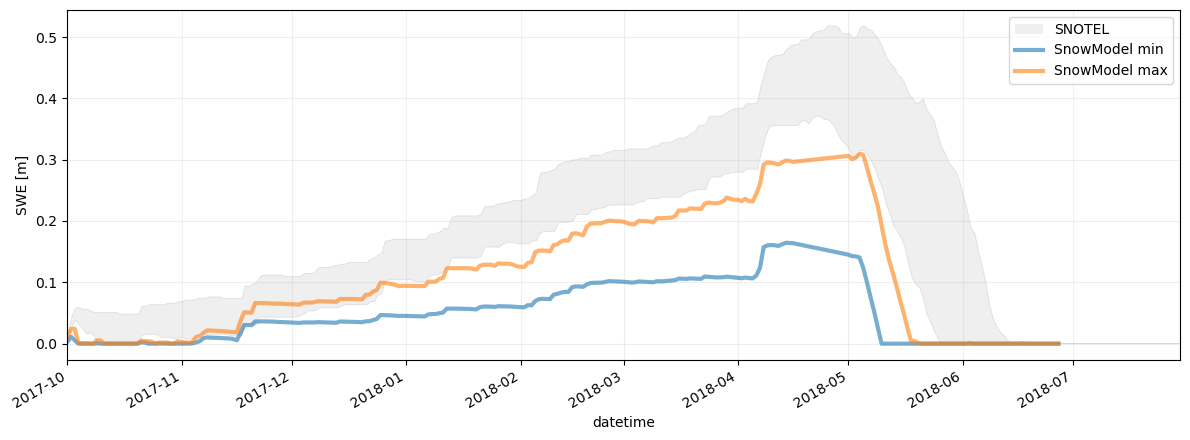

In [50]:
alpha = 0.1
fig, ax = plt.subplots(1, figsize=(12, 4.5))

snotelon = True
snotel_dotson = False
gridon = True

if snotelon:
    # Plot WY time series of snow depth
    if snotel_dotson:
        snotel_megadf.plot(ax=ax, legend=False,
                           linewidth=linewidth/3,
                           color=snotelcolor, marker='.', markersize=3,
                           alpha=alpha*2
                          )

    snotel_megadf.min(axis=1).plot(ax=ax, legend=False,
                                   # linewidth=0,
                                   linewidth=linewidth/3,
                                   color=snotelcolor, marker='.', markersize=0, #markersize=3,
                                   alpha=alpha*2
                                  )

    snotel_megadf.max(axis=1).plot(ax=ax, legend=False,
                                   # linewidth=0,
                                   linewidth=linewidth/3,
                                   color=snotelcolor, marker='.', markersize=0, #markersize=3,
                                   alpha=alpha*2
                                  )

    ax.fill_between(snotel_megadf.index, 
                    snotel_megadf.min(axis=1), 
                    snotel_megadf.max(axis=1), facecolor=snotelcolor, label='SNOTEL', 
                    alpha=alpha)

# SnowModel
depth_megadf.min(axis=1).plot(ax=ax, x='Date', label='SnowModel min', linewidth=linewidth*2, linestyle='-', 
                              alpha=isnobal_alpha,
                             )
depth_megadf.max(axis=1).plot(ax=ax, x='Date', label='SnowModel max', linewidth=linewidth*2, linestyle='-', 
                              alpha=isnobal_alpha
                             )

# Center the plot on the data
ax.set_xlim(pd.Timestamp(f'{WY-1}-10-01'), pd.Timestamp(f'{WY}-07-30'));
ax.set_ylabel('SWE [m]')
plt.legend()
plt.tight_layout()
if gridon:
    ax.grid(alpha=0.2)
# plt.legend(bbox_to_anchor=(0.205,1))
# plt.legend(bbox_to_anchor=(0.195,1))
outname = f'{basin}_ts.png'
# outname = f'{basin}_snotel_nwm_ts.png'
# outname = f'{basin}_snotel.png'
# plt.savefig(outname, dpi=300)